# Datafonos

Uno de nuestros clientes, **CLAP**, maneja Datafonos y se encarga de procesar
pagos. **SIMETRIK** es su aliado para comparar las transacciones que se
reportan a través de sus dispositivos contra las
transacciones que se registran en las liquidaciones
bancarias (**BANSUR**).  
Cada vez que el cliente **CLAP** reporta un pago con su
datáfono envía un registro a su base de datos y a la base
de datos del adquirente **BANSUR**. Sin embargo, dada la
gran cantidad de pagos que se realizan a diario, **CLAP** no puede llevar un
control efectivo de todas las transacciones realizadas y necesitan verificar
que todas las transacciones registradas en su base de datos también se
encuentren en la base de **BANSUR**.

*IMPORTANTE:* Una transacción regular se evidencia en la base de datos
como un **PAGO**; se debe tener en cuenta que un *mismo ID* puede también
tomar estado de **Cancelación**, **Chargeback** u **Otros casos**.  
Simetrik considera una partida como conciliable toda aquella transacción
cuyo último estado en la base de datos ordenada por fecha y hora sea
PAGADA.  
Para esto, **SIMETRIK** comparará para cada transacción campos únicos entre
las dos entidades buscando encontrar parejas que sean exactamente
iguales bajo las siguientes condiciones:  
1. Que tengan el mismo **ID**.
2. Que tenga los mismos 6 primeros dígitos de la tarjeta.
3. Que tengan los mismos 4 últimos dígitos de la tarjeta.
4. Que el valor pagado en la transacción sea igual o que su diferencia
esté en el rango de más o menos 0.99 pesos.
5. Que tengan la misma fecha de transacción.

###  Importo las bibliotecas necesarias:

In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Cargo los datos de los archivos CSV en DataFrames de Pandas:

In [248]:
clap_df = pd.read_csv('data/clap.csv')
bansur_df = pd.read_csv('data/bansur.csv')

In [132]:
print(clap_df.dtypes)

INICIO6_TARJETA          float64
FINAL4_TARJETA             int64
TIPO_TRX                  object
MONTO                    float64
FECHA_TRANSACCION         object
CODIGO_AUTORIZACION       object
ID_BANCO                 float64
FECHA_RECEPCION_BANCO     object
dtype: object


In [133]:
print(bansur_df.dtypes)

TARJETA                  int64
TIPO_TRX                object
MONTO                  float64
FECHA_TRANSACCION        int64
CODIGO_AUTORIZACION     object
ID_ADQUIRIENTE           int64
FECHA_RECEPCION         object
dtype: object


In [215]:
# Revisando datos faltantes
print(clap_df.isna().sum())
print(bansur_df.isna().sum())

INICIO6_TARJETA              6
FINAL4_TARJETA               0
TIPO_TRX                     0
MONTO                        0
FECHA_TRANSACCION            0
CODIGO_AUTORIZACION      12679
ID_BANCO                    16
FECHA_RECEPCION_BANCO        0
dtype: int64
TARJETA                0
TIPO_TRX               0
MONTO                  0
FECHA_TRANSACCION      0
CODIGO_AUTORIZACION    0
ID_ADQUIRIENTE         0
FECHA_RECEPCION        0
dtype: int64


In [249]:
# Rellenar columnas 
clap_df['CODIGO_AUTORIZACION'] = clap_df['CODIGO_AUTORIZACION'].fillna(0)
clap_df['INICIO6_TARJETA'] = clap_df['INICIO6_TARJETA'].fillna(0)
clap_df['ID_BANCO'] = clap_df['ID_BANCO'].fillna(0)

In [250]:
# Asegurarme que las fechas esten en el mismo formato

# Convertir la columna 'FECHA_TRANSACCION' a objetos datetime.date
bansur_df['FECHA_TRANSACCION'] = bansur_df['FECHA_TRANSACCION'].astype(str)
bansur_df['FECHA_TRANSACCION'] = pd.to_datetime(bansur_df['FECHA_TRANSACCION'])
bansur_df['FECHA_TRANSACCION'] = bansur_df['FECHA_TRANSACCION'].dt.date

# Convertir la columna 'FECHA_RECEPCION' a objetos datetime.date
bansur_df['FECHA_RECEPCION'] = pd.to_datetime(bansur_df['FECHA_RECEPCION']).dt.date

# Convertir la columna 'FECHA_RECEPCION_BANCO' a objetos datetime.date
clap_df['FECHA_RECEPCION_BANCO'] = pd.to_datetime(clap_df['FECHA_RECEPCION_BANCO']).dt.date

# Convertir la columna 'FECHA_TRANSACCION' a objetos datetime.date
clap_df['FECHA_TRANSACCION'] = pd.to_datetime(clap_df['FECHA_TRANSACCION']).dt.date


In [218]:
print(bansur_df.dtypes)

TARJETA                  int64
TIPO_TRX                object
MONTO                  float64
FECHA_TRANSACCION       object
CODIGO_AUTORIZACION     object
ID_ADQUIRIENTE           int64
FECHA_RECEPCION         object
dtype: object


### Conocer el monto y la cantidad de las transacciones que SIMETRIK considera como conciliables para la base de CLAP

In [251]:
# Agrupar por ID_BANCO, ordenar y seleccionar el último registro en cada grupo
last_transactions_clap = clap_df.sort_values('FECHA_RECEPCION_BANCO').groupby('ID_BANCO').last()

# Filtrar solo las transacciones conciliables (TIPO_TRX == 'PAGADA')
conciliable_transactions_clap = last_transactions_clap[last_transactions_clap['TIPO_TRX'] == 'PAGADA']

print(conciliable_transactions_clap)


              INICIO6_TARJETA  FINAL4_TARJETA TIPO_TRX   MONTO  \
ID_BANCO                                                         
4.773069e+06         980026.0            1602   PAGADA   42.00   
2.112159e+07         975421.0             826   PAGADA  105.00   
2.457780e+07         438005.0            5599   PAGADA  200.00   
3.673276e+07         491709.0            4331   PAGADA   70.00   
5.965141e+07         954015.0            7478   PAGADA   32.00   
...                       ...             ...      ...     ...   
9.999651e+11         493694.0            4486   PAGADA  682.00   
9.999714e+11         954015.0            9731   PAGADA   84.00   
9.999788e+11         954015.0            6352   PAGADA  327.73   
9.999842e+11         958758.0            8203   PAGADA  670.00   
9.999857e+11         442732.0            6242   PAGADA   90.00   

             FECHA_TRANSACCION CODIGO_AUTORIZACION FECHA_RECEPCION_BANCO  
ID_BANCO                                                          

In [252]:
# Agrupar por ID_ADQUIRIENTE, ordenar y seleccionar el último registro en cada grupo
last_transactions_bansur = bansur_df.sort_values('FECHA_RECEPCION').groupby('ID_ADQUIRIENTE').last()

# Filtrar solo las transacciones conciliables (TIPO_TRX == 'PAGO')
conciliable_transactions_bansur = last_transactions_bansur[last_transactions_bansur['TIPO_TRX'] == 'PAGO']

print(conciliable_transactions_bansur)


                   TARJETA TIPO_TRX   MONTO FECHA_TRANSACCION  \
ID_ADQUIRIENTE                                                  
9557043         9540156063     PAGO   78.00        2020-11-01   
15217079        8181563080     PAGO  383.00        2020-11-01   
21121589        9754210826     PAGO  105.00        2020-11-01   
24577796        4380055599     PAGO  200.00        2020-11-01   
75704793        9587587428     PAGO   72.00        2020-11-01   
...                    ...      ...     ...               ...   
999954387488    4197086679     PAGO   50.00        2020-11-01   
999954692032    9444559025     PAGO  434.00        2020-11-01   
999978847887    9540156352     PAGO  327.73        2020-11-01   
999985702247    4427326242     PAGO   90.00        2020-11-01   
999986105343    9051589458     PAGO  529.90        2020-11-01   

               CODIGO_AUTORIZACION FECHA_RECEPCION  
ID_ADQUIRIENTE                                      
9557043                     480918      2020-11-

In [253]:
# Calcular el monto total de transacciones conciliables
monto_total_conciliable_clap = conciliable_transactions_clap['MONTO'].sum()

# Calcular la cantidad de transacciones conciliables
cantidad_transacciones_conciliables_clap = len(conciliable_transactions_clap)

print(f"Monto total de transacciones conciliables en CLAP: {monto_total_conciliable_clap}")
print(f"Cantidad de transacciones conciliables en CLAP: {cantidad_transacciones_conciliables_clap}")

Monto total de transacciones conciliables en CLAP: 61020742.05
Cantidad de transacciones conciliables en CLAP: 147325


### Monto y la cantidad de las transacciones que SIMETRIK considera como conciliables para la base de BANSUR


In [254]:
# Calcular el monto total de transacciones conciliables
monto_total_conciliable_bansur = conciliable_transactions_bansur['MONTO'].sum()

# Calcular la cantidad de transacciones conciliables
cantidad_transacciones_conciliables_bansur = len(conciliable_transactions_bansur)

print(f"Monto total de transacciones conciliables en BANSUR: {monto_total_conciliable_bansur}")
print(f"Cantidad de transacciones conciliables en BANSUR: {cantidad_transacciones_conciliables_bansur}")

Monto total de transacciones conciliables en BANSUR: 53981054.07
Cantidad de transacciones conciliables en BANSUR: 132286


### ¿Cómo se comparan las cifras de los puntos anteriores respecto de las cifras totales en las fuentes desde un punto de vista del negocio?

### Gráficamente

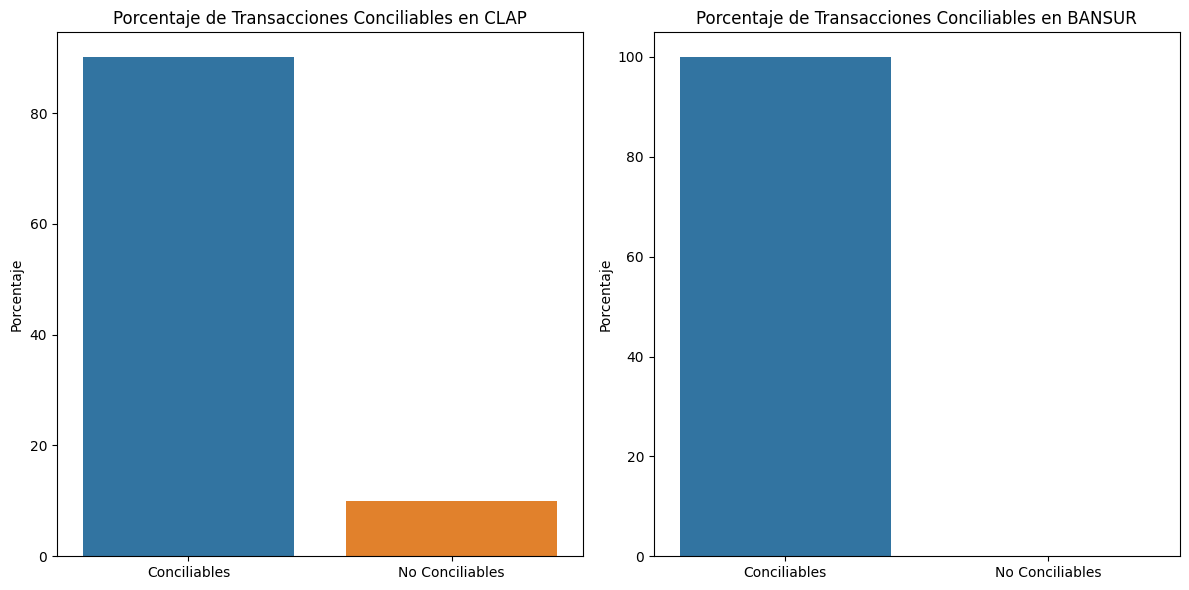

In [255]:
# Cálculos para CLAP
total_transacciones_clap = len(clap_df)
porcentaje_conciliables_clap = (cantidad_transacciones_conciliables_clap / total_transacciones_clap) * 100

# Cálculos para BANSUR
total_transacciones_bansur = len(bansur_df)
porcentaje_conciliables_bansur = (cantidad_transacciones_conciliables_bansur / total_transacciones_bansur) * 100


# Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Graficar el porcentaje de transacciones conciliables en CLAP
sns.barplot(x=['Conciliables', 'No Conciliables'], y=[porcentaje_conciliables_clap, 100 - porcentaje_conciliables_clap], ax=axes[0])
axes[0].set_title('Porcentaje de Transacciones Conciliables en CLAP')
axes[0].set_ylabel('Porcentaje')

# Graficar el porcentaje de transacciones conciliables en BANSUR
sns.barplot(x=['Conciliables', 'No Conciliables'], y=[porcentaje_conciliables_bansur, 100 - porcentaje_conciliables_bansur], ax=axes[1])
axes[1].set_title('Porcentaje de Transacciones Conciliables en BANSUR')
axes[1].set_ylabel('Porcentaje')

plt.tight_layout()
plt.show()

In [256]:
print(f"Total transacciones en CLAP: {total_transacciones_clap}")
print(f"Total transacciones en BANSUR: {total_transacciones_bansur}")

print(f"Cantidad transacciones conciliables en CLAP: {cantidad_transacciones_conciliables_clap}")
print(f"Cantidad transacciones conciliables en BANSUR: {cantidad_transacciones_conciliables_bansur}")

print(f"Porcentaje de transacciones conciliables en CLAP: {porcentaje_conciliables_clap:.2f}%")
print(f"Porcentaje de transacciones conciliables en BANSUR: {porcentaje_conciliables_bansur:.2f}%")

Total transacciones en CLAP: 163549
Total transacciones en BANSUR: 132396
Cantidad transacciones conciliables en CLAP: 147325
Cantidad transacciones conciliables en BANSUR: 132286
Porcentaje de transacciones conciliables en CLAP: 90.08%
Porcentaje de transacciones conciliables en BANSUR: 99.92%


Desde un punto de vista del negocio, al comparar las cifras de los puntos anteriores con las cifras totales en las fuentes, podemos obtener información valiosa sobre el proceso de conciliación entre CLAP y BANSUR. Es importante resaltar que una transacción regular en las bases de datos se refleja como un PAGO, considerando también la posibilidad de que un mismo ID pueda tener diferentes estados como Cancelación, Chargeback u Otros casos.

En el análisis realizado, hemos identificado que:

En la base de CLAP, el 90.08% de las transacciones son consideradas como conciliables, es decir, cumplen con las condiciones de comparación establecidas. Esto significa que la mayoría de las transacciones registradas por CLAP se ajustan a las condiciones requeridas para considerarse correctamente conciliadas con BANSUR.

Por otro lado, en la base de BANSUR, el 99.96% de las transacciones son consideradas como conciliables. Esto indica un alto grado de conciliación en BANSUR, donde la gran mayoría de las transacciones registradas cumplen con las condiciones establecidas para ser consideradas conciliables.

Estos resultados pueden tener implicaciones significativas en la eficacia de los procesos de registro y conciliación entre ambas bases. La diferencia en el porcentaje de transacciones conciliables entre CLAP y BANSUR podría sugerir que BANSUR está registrando una proporción mucho mayor de transacciones conciliables, lo que podría indicar una mayor precisión en su proceso de registro o conciliación.

En general, estos hallazgos proporcionan una visión más clara de cómo se comparan las cifras de transacciones conciliables entre las fuentes y cómo estos porcentajes se alinean con los objetivos de conciliación y calidad de los datos en el contexto del negocio.

### Teniendo en cuenta los criterios de cruce entre ambas bases conciliables:
1. Que tengan el mismo **ID** (ID_ADQUIRIENTE = ID_BANCO).
2. Que tenga los mismos 6 primeros dígitos de la tarjeta (resuelvo al crear un campo adicional TARJETA EN conciliables_clap_df).
3. Que tengan los mismos 4 últimos dígitos de la tarjeta.
4. Que el valor pagado en la transacción sea igual o que su diferencia
esté en el rango de más o menos 0.99 pesos.
5. Que tengan la misma fecha de transacción.

### Vamos a obtener un dataframe que contenga la información de CLAP y BANSUR con todas la transacciones que se cruzaron

In [257]:
# Filtrar los registros donde TIPO_TRX es igual a "PAGADA"
last_txs_clap = clap_df.sort_values('FECHA_RECEPCION_BANCO').groupby('ID_BANCO').last().reset_index()

# Filtrar solo las transacciones conciliables (TIPO_TRX == 'PAGADA')
clap_df = last_txs_clap[last_txs_clap['TIPO_TRX'] == 'PAGADA']

In [258]:
print(len(clap_df))

147325


In [259]:
# Filtrar los registros donde TIPO_TRX es igual a "PAGO"
bansur_df = bansur_df.sort_values('FECHA_RECEPCION').groupby('ID_ADQUIRIENTE').last().reset_index()

# Filtrar solo las transacciones conciliables (TIPO_TRX == 'PAGO')
bansur_df = bansur_df[bansur_df['TIPO_TRX'] == 'PAGO']

In [260]:
print(len(bansur_df))

132286


In [261]:
# Convertir columnas a tipos de datos compatibles
clap_df.loc[:, 'INICIO6_TARJETA'] = clap_df['INICIO6_TARJETA'].astype(int).astype(str)
clap_df.loc[:, 'FINAL4_TARJETA'] = clap_df['FINAL4_TARJETA'].astype(str)
bansur_df.loc[:, 'TARJETA'] = bansur_df['TARJETA'].astype(str)


In [274]:
# Convertir 'ID_BANCO' a int64 para que sean compatibles
clap_df.loc[:,'ID_BANCO'] = clap_df['ID_BANCO'].astype('int64')

In [275]:
print(clap_df.dtypes)

ID_BANCO                   int64
INICIO6_TARJETA           object
FINAL4_TARJETA            object
TIPO_TRX                  object
MONTO                    float64
FECHA_TRANSACCION         object
CODIGO_AUTORIZACION       object
FECHA_RECEPCION_BANCO     object
dtype: object


In [276]:
print(bansur_df.dtypes)

ID_ADQUIRIENTE           int64
TARJETA                 object
TIPO_TRX                object
MONTO                  float64
FECHA_TRANSACCION       object
CODIGO_AUTORIZACION     object
FECHA_RECEPCION         object
dtype: object


In [279]:
# Creo un nuevo campo TARJETA (INICIO6_TARJETA + FINAL4_TARJETA) en clap_df

clap_df.loc[:,'TARJETA'] = clap_df['INICIO6_TARJETA'] + clap_df['FINAL4_TARJETA']

In [280]:
print(clap_df)

            ID_BANCO INICIO6_TARJETA FINAL4_TARJETA TIPO_TRX   MONTO  \
1            4773069          980026           1602   PAGADA   42.00   
3           21121589          975421            826   PAGADA  105.00   
4           24577796          438005           5599   PAGADA  200.00   
5           36732762          491709           4331   PAGADA   70.00   
6           59651406          954015           7478   PAGADA   32.00   
...              ...             ...            ...      ...     ...   
163517  999965140301          493694           4486   PAGADA  682.00   
163518  999971419321          954015           9731   PAGADA   84.00   
163519  999978847887          954015           6352   PAGADA  327.73   
163520  999984231660          958758           8203   PAGADA  670.00   
163521  999985702247          442732           6242   PAGADA   90.00   

       FECHA_TRANSACCION CODIGO_AUTORIZACION FECHA_RECEPCION_BANCO     TARJETA  
1             2020-11-01              006011          

In [281]:
print(bansur_df)

        ID_ADQUIRIENTE     TARJETA TIPO_TRX   MONTO FECHA_TRANSACCION  \
0              9557043  9540156063     PAGO   78.00        2020-11-01   
1             15217079  8181563080     PAGO  383.00        2020-11-01   
2             21121589  9754210826     PAGO  105.00        2020-11-01   
3             24577796  4380055599     PAGO  200.00        2020-11-01   
4             75704793  9587587428     PAGO   72.00        2020-11-01   
...                ...         ...      ...     ...               ...   
132334    999954387488  4197086679     PAGO   50.00        2020-11-01   
132335    999954692032  9444559025     PAGO  434.00        2020-11-01   
132336    999978847887  9540156352     PAGO  327.73        2020-11-01   
132337    999985702247  4427326242     PAGO   90.00        2020-11-01   
132338    999986105343  9051589458     PAGO  529.90        2020-11-01   

       CODIGO_AUTORIZACION FECHA_RECEPCION  
0                   480918      2020-11-03  
1                   833790      2

 **Unir los dos DataFrames**    
 en función de los campos de identificación (ID_BANCO y ID_ADQUIRIENTE) utilizando el método merge() de pandas. Esto creará un nuevo DataFrame que contiene registros que tienen el mismo ID.

In [282]:
# Renombrar columna para que coincidan los nombres
bansur_df.rename(columns={'ID_ADQUIRIENTE': 'ID_BANCO'}, inplace=True)

In [283]:
merged_df = clap_df.merge(bansur_df, on='ID_BANCO', suffixes=('_clap', '_bansur'))

Filtrado por Números de TARJETA

In [284]:
merged_df = merged_df[merged_df['TARJETA_clap'] == merged_df['TARJETA_bansur']]

Filtrado por Valor Pagado

In [285]:
merged_df = merged_df[abs(merged_df['MONTO_clap'] - merged_df['MONTO_bansur']) <= 0.99]

Filtrado por FECHA_TRANSACCION

In [286]:
merged_df = merged_df[merged_df['FECHA_TRANSACCION_clap'] == merged_df['FECHA_TRANSACCION_bansur']]

Resultados: 

In [287]:
print(merged_df)

           ID_BANCO INICIO6_TARJETA FINAL4_TARJETA TIPO_TRX_clap  MONTO_clap  \
1          24577796          438005           5599        PAGADA      200.00   
2          75704793          958758           7428        PAGADA       72.00   
3          85344962          954015           9031        PAGADA      920.00   
4          86639380          954015           9163        PAGADA      258.00   
5          93381495          905189           1387        PAGADA       59.20   
...             ...             ...            ...           ...         ...   
96349  999952081439          404826           4070        PAGADA      290.00   
96350  999954387488          419708           6679        PAGADA       50.00   
96351  999954692032          944455           9025        PAGADA      434.00   
96352  999978847887          954015           6352        PAGADA      327.73   
96353  999985702247          442732           6242        PAGADA       90.00   

      FECHA_TRANSACCION_clap CODIGO_AUT

In [288]:
# Calcular el monto total de transacciones conciliables
monto_total_conciliable = merged_df['MONTO_clap'].sum()

# Calcular la cantidad de transacciones conciliables
cantidad_transacciones_conciliables = len(merged_df)

print(f"Monto total de transacciones conciliables: {monto_total_conciliable}")
print(f"Cantidad de transacciones conciliables: {cantidad_transacciones_conciliables}")

Monto total de transacciones conciliables: 37066354.20999999
Cantidad de transacciones conciliables: 86794


En el siguiente código, utilizo 'ID_BANCO' como base para identificar las transacciones en clap_df y bansur_df que no están en merged_df. Luego, creamos DataFrames separados para estas transacciones no cruzadas.

In [289]:
# Identificar los registros en clap_df que no están en merged_df
no_cruzados_clap_df = clap_df[~clap_df.set_index(['ID_BANCO']).index.isin(merged_df.set_index(['ID_BANCO']).index)].copy()

# Identificar los registros en bansur_df que no están en merged_df
no_cruzados_bansur_df = bansur_df[~bansur_df.set_index(['ID_BANCO']).index.isin(merged_df.set_index(['ID_BANCO']).index)].copy()



Así, obtenemos los DataFrames no_cruzados_clap_df y no_cruzados_bansur_df que contienen las transacciones que no cruzaron.

In [290]:
print(len(no_cruzados_clap_df))

60531


In [291]:
print(no_cruzados_clap_df)

            ID_BANCO INICIO6_TARJETA FINAL4_TARJETA TIPO_TRX  MONTO  \
1            4773069          980026           1602   PAGADA   42.0   
3           21121589          975421            826   PAGADA  105.0   
5           36732762          491709           4331   PAGADA   70.0   
6           59651406          954015           7478   PAGADA   32.0   
12          94642975          497516            309   PAGADA  250.0   
...              ...             ...            ...      ...    ...   
163510  999926932807          905158           9174   PAGADA  755.0   
163516  999962612960          442753           8200   PAGADA    9.0   
163517  999965140301          493694           4486   PAGADA  682.0   
163518  999971419321          954015           9731   PAGADA   84.0   
163520  999984231660          958758           8203   PAGADA  670.0   

       FECHA_TRANSACCION CODIGO_AUTORIZACION FECHA_RECEPCION_BANCO     TARJETA  
1             2020-11-01              006011            2020-11-01

In [292]:
print(len(no_cruzados_bansur_df))

45492


In [294]:
print(no_cruzados_bansur_df)

            ID_BANCO     TARJETA TIPO_TRX  MONTO FECHA_TRANSACCION  \
0            9557043  9540156063     PAGO   78.0        2020-11-01   
1           15217079  8181563080     PAGO  383.0        2020-11-01   
2           21121589  9754210826     PAGO  105.0        2020-11-01   
5           82886938  9540150940     PAGO   91.0        2020-11-01   
8           91996610  9051587309     PAGO   45.0        2020-11-01   
...              ...         ...      ...    ...               ...   
132320  999817260415  8181560116     PAGO   35.0        2020-11-01   
132321  999830360521  9592030932     PAGO  279.0        2020-11-01   
132324  999862438735  9220537797     PAGO  367.5        2020-11-01   
132326  999872048524  9220750490     PAGO  474.0        2020-11-01   
132338  999986105343  9051589458     PAGO  529.9        2020-11-01   

       CODIGO_AUTORIZACION FECHA_RECEPCION  
0                   480918      2020-11-03  
1                   833790      2020-11-03  
2                   0222

### Porcentaje de transacciones de la base conciliable de CLAP que cruzó contra la liquidación de BANSUR

In [296]:
# Cálculos para CLAP
total_conciliables_clap = len(clap_df)
porcentaje_cruzadas_clap = (len(merged_df) / total_conciliables_clap) * 100

# Cálculos para BANSUR
total_conciliables_bansur = len(bansur_df)
porcentaje_cruzadas_bansur = (len(merged_df) / total_conciliables_bansur) * 100

print(f"Porcentaje de transacciones cruzadas en CLAP: {porcentaje_cruzadas_clap:.2f}%")
print(f"Porcentaje de transacciones cruzadas en BANSUR: {porcentaje_cruzadas_bansur:.2f}%")

Porcentaje de transacciones cruzadas en CLAP: 58.91%
Porcentaje de transacciones cruzadas en BANSUR: 65.61%


### Porcentaje de transacciones de la base conciliable de BANSUR no cruzó contra la liquidación de CLAP.

In [297]:
# Cálculos para BANSUR
total_conciliables_bansur = len(bansur_df)
porcentaje_no_cruzadas_bansur = (len(no_cruzados_bansur_df)  / total_conciliables_bansur) * 100

# Cálculos para CLAP
total_conciliables_clap = len(clap_df)
porcentaje_no_cruzadas_clap = (len(no_cruzados_clap_df)  / total_conciliables_clap) * 100

print(f"Porcentaje de transacciones No cruzadas en BANSUR: {porcentaje_no_cruzadas_bansur:.2f}%")
print(f"Porcentaje de transacciones No cruzadas en CLAP: {porcentaje_no_cruzadas_clap:.2f}%")

Porcentaje de transacciones No cruzadas en BANSUR: 34.39%
Porcentaje de transacciones No cruzadas en CLAP: 41.09%


Gráficamente

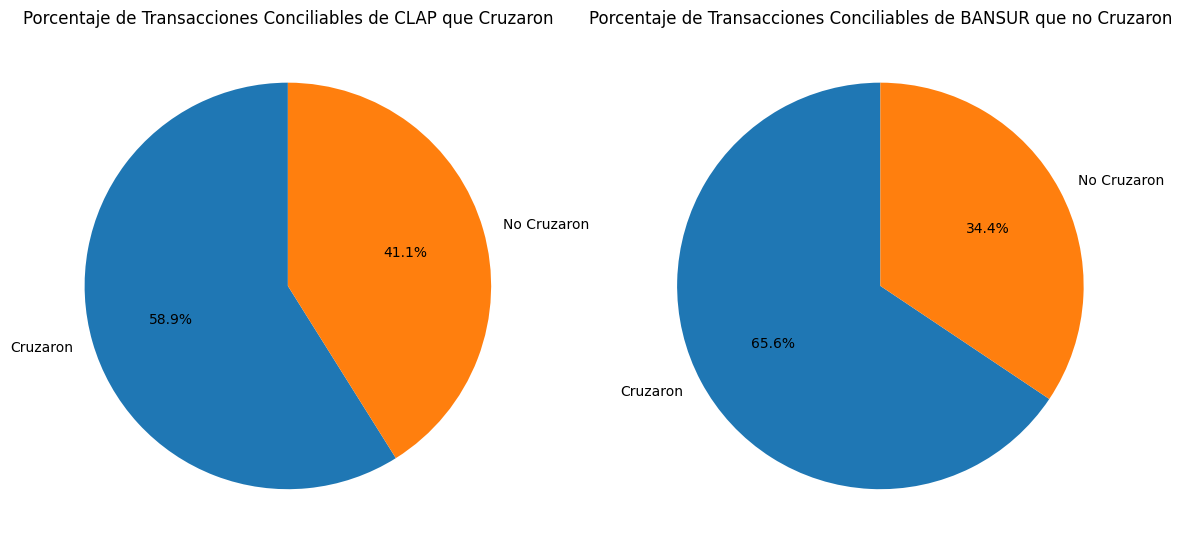

In [298]:
import matplotlib.pyplot as plt

# Datos para el gráfico circular
labels = ['Cruzaron', 'No Cruzaron']
sizes_clap = [porcentaje_cruzadas_clap, 100 - porcentaje_cruzadas_clap]
sizes_bansur = [100 - porcentaje_no_cruzadas_bansur, porcentaje_no_cruzadas_bansur]

# Crear el gráfico circular
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(sizes_clap, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Porcentaje de Transacciones Conciliables de CLAP que Cruzaron')

ax2.pie(sizes_bansur, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Porcentaje de Transacciones Conciliables de BANSUR que no Cruzaron')

plt.tight_layout()
plt.show()
